In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.style as style
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('nba_complete_2015-2019.csv')
pd.set_option('max_columns', None)
df.head(20)

,PLAYER_NAME,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,two_pt_fg_pct,three_pt_fg_pct,DRIVES,DRIVE_FGM,DRIVE_FGA,DRIVE_PASSES,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,TOUCHES,FRONT_CT_TOUCHES,TIME_OF_POSS,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG3M,PULL_UP_FG3A,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF
0,Quincy Acy (15-16),PF,25,SAC,59,29,876,6.5,11.7,0.556,1.0,2.7,0.388,5.5,9.0,0.606,2.7,3.7,0.735,3.6,6.7,10.3,1.5,1.6,1.3,1.5,5.6,16.8,124.0,108,14.7,0.629,0.229,0.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,0.137,-0.2,0.2,-0.1,0.4,0.771,0.229,0.606,0.388,26,7,12,9,32,79,16.0,46.0,1116,602,23.3,5,10,2.0,2.0,62.4,32.3,30.1
1,Jordan Adams (15-16),SG,21,MEM,2,0,15,6.9,20.6,0.333,0.0,3.4,0.000,6.9,17.2,0.400,10.3,17.2,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,6.9,24.0,84.0,90,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,0.015,-2.5,9.4,6.9,0.0,0.833,0.167,0.400,0.000,1,0,0,1,0,1,0.0,1.0,22,12,0.8,1,3,0.0,0.0,1.2,0.6,0.5
2,Steven Adams (15-16),C,22,OKC,80,80,2014,6.4,10.5,0.613,0.0,0.0,NaN,6.4,10.5,0.613,2.8,4.8,0.582,5.4,7.7,13.1,1.5,1.0,2.2,2.1,5.5,15.7,123.0,105,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,0.155,0.0,0.2,0.2,1.1,1.000,0.000,0.613,NaN,14,1,7,5,4,10,NaN,NaN,3601,1421,81.9,0,2,NaN,NaN,143.0,77.2,65.8
3,Arron Afflalo (15-16),SG,30,NYK,71,57,2371,7.7,17.3,0.443,2.0,5.2,0.382,5.7,12.2,0.469,2.4,2.8,0.840,0.5,5.3,5.8,3.1,0.5,0.2,1.8,3.1,19.7,105.0,112,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,0.055,-1.3,-1.6,-2.9,-0.5,0.702,0.298,0.469,0.382,224,44,106,68,123,299,76.0,196.0,3744,2749,157.5,132,292,12.0,37.0,165.9,92.4,73.5
4,Alexis Ajinca (15-16),C,27,NOP,59,17,861,8.6,18.1,0.476,0.0,0.1,0.000,8.6,18.1,0.478,3.0,3.6,0.839,4.3,11.2,15.5,1.8,1.1,2.1,3.1,7.7,20.3,100.0,107,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,0.058,-3.4,-0.6,-4.0,-0.4,0.997,0.003,0.478,0.000,27,7,19,4,51,122,0.0,1.0,1485,773,34.7,10,21,0.0,0.0,58.3,30.4,27.9
5,Cole Aldrich (15-16),C,27,LAC,60,5,800,8.4,14.1,0.596,0.0,0.0,NaN,8.4,14.1,0.596,3.8,5.3,0.714,5.4,12.7,18.0,3.1,2.9,4.3,4.0,8.7,20.5,113.0,94,21.3,0.626,0.000,0.373,11.9,27.1,19.6,10.0,2.9,6.7,19.6,18.4,1.4,2.0,3.5,0.209,-0.9,3.4,2.4,0.9,1.000,0.000,0.596,NaN,7,1,3,3,0,0,NaN,NaN,1604,817,39.6,0,2,NaN,NaN,55.5,29.6,25.9
6,LaMarcus Aldridge (15-16),PF,30,SAS,74,74,2261,12.1,23.7,0.513,0.0,0.4,0.000,12.1,23.3,0.521,5.9,6.8,0.858,4.0,10.3,14.3,2.5,0.9,1.8,2.2,3.4,30.1,114.0,99,22.4,0.565,0.015,0.289,9.2,22.2,15.9,8.1,0.9,2.8,7.8,25.9,5.6,4.5,10.1,0.215,2.0,0.3,2.3,2.5,0.985,0.015,0.521,0.000,86,25,50,15,149,337,0.0,15.0,4126,2781,123.1,79,221,0.0,1.0,153.7,82.8,70.8
7,Cliff Alexander (15-16),PF,20,POR,8,0,36,6.9,13.9,0.500,0.0,0.0,NaN,6.9,13.9,0.500,0.0,0.0,NaN,2.8,5.6,8.3,0.0,1.4,2.8,1.4,1.4,13.9,100.0,107,11.6,0.500,0.000,0.000,6.0,12.1,9.0,0.0,1.4,4.4,9.1,13.3,0.0,0.0,0.0,0.052,-0.5,0.5,0.0,0.0,1.000,0.000,0.500,NaN,0,0,0,0,0,2,NaN,NaN,50,26,1.3,1,1,NaN,NaN,2.6,1.4,1.2
8,Lavoy Allen (15-16),PF,26,IND,79,28,1599,5.9,11.5,0.516,0.0,0.0,NaN,5.9,11.5,0.516,1.4,2.3,0.630,5.0,8.1,13.2,2.4,0.8,1.3,2.1,4.6,13.3,110.0,104,12.4,0.532,0.000,0.197,11.1,17.8,14.5,7.1,0.8,2.1,14.6,13.0,1.6,2.1,3.7,0.110,-1.7,0.1,-1.6,0.2,1.000,0.000,0.516,NaN,12,1,7,3,45,121,NaN,NaN,2603,1512,65.4,3,5,NaN,NaN,109.8,57.8,52.0
9,Tony Allen (15-16),SG,34,MEM,64,57,1620,6.8,14.9,0.458,0.5,1.3,0.357,6.4,13.6,0.468,2.9,4.4,0.652,3.3,6.1,9.4,2.2,3.5,0.6,2.5,5.6,17.0,101.0,105,12.9,0.505,0.090,0.294,7.0,14.1,10.4,6.9,3.5,1.0,12.8,16.8,0.5,1.9,2.4,0.072,-2.2,1.2,-1.0,0.4,0.910,0.090,0.468,0.357,194,34,93,56,30,84,15.0,42.0,1957,1346,79.0,13,34,0.0,0.0,112.2,58.4,53.7


In [3]:
#Dropping duplicate columns ('two_pt_fg_pct' and 'three_pt_fg_pct')
df = df.drop(columns = ['two_pt_fg_pct', 'three_pt_fg_pct'])

In [4]:
pd.set_option('display.max_rows', None)
df.isna().sum()

PLAYER_NAME            0
Pos                    0
Age                    0
Tm                     0
G                      0
GS                     0
MP                     0
FG                     0
FGA                    0
FG%                    9
3P                     0
3PA                    0
3P%                  164
2P                     0
2PA                    0
2P%                   28
FT                     0
FTA                    0
FT%                   95
ORB                    0
DRB                    0
TRB                    0
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
PTS                    0
ORtg                   8
DRtg                   0
PER                    0
TS%                    9
3PAr                   9
FTr                    9
ORB%                   0
DRB%                   0
TRB%                   0
AST%                   0
STL%                   0
BLK%                   0


In [ ]:
#We will likely replace all null values with 0. Looking at the columns it seems that null values were created
#by dividing by zero (i.e. 3PT%  = 3PTs made/ 3PTs attempted and a player with zero 3PT attempts will have zero 
# which can be interepreted as 0%. Mathematically it would be 0/0, which is undefined hence the null values in 
#some rows

#Null values in the distance miles column doesn't make sense as it should either be zero or some float number 
# greater than zero

#We see that there is one player who has null values as for the distance metrics. It is likely this player
#only played one game and was possibly substituted in at the end of a game so that the game could be finished.

#Nonetheless we will substitute all null values with 0 and use conditions to filter out players who did not have
#meaningful possessions.



In [5]:
df.fillna(0, inplace=True)

In [ ]:
#Now we will need to do some additional math to add another player evaluation metric:
#PPP - Points per possession

#We will also do some math to transform the nba tracking statistics from season aggregates to per game stats.
#It's much more intuitive to think about how many miles a player traveled on the court in a single game
#rather than over the course of a season.
#One item of note: The box score statistics from basketball reference are per 100 possessions. Per 100 possessions
#are typically better for analysis because it eliminates discrepancies in pace and style of play 
#Teams that play at a faster pace won't have a statistical advantage over teams that play slower
#Also not all games are created equal - some games go into a single or multiple overtimes 

In [6]:
#check columns as we will use indexing to write a loop to transform aggregate statistics
df.columns

Index(['PLAYER_NAME', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'pct_of_FGA_twos', 'pct_of_FGA_threes', 'DRIVES',
       'DRIVE_FGM', 'DRIVE_FGA', 'DRIVE_PASSES', 'CATCH_SHOOT_FGM',
       'CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3M', 'CATCH_SHOOT_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'TIME_OF_POSS', 'PULL_UP_FGM', 'PULL_UP_FGA',
       'PULL_UP_FG3M', 'PULL_UP_FG3A', 'DIST_MILES', 'DIST_MILES_OFF',
       'DIST_MILES_DEF'],
      dtype='object')

In [7]:
df['MPG'] = df['MP']/df['G'] #calculate minutes per game

#calculate per game drive stats and drive field goal percentage 
df['DRIVES/GM'] = df['DRIVES']/df['G']
df['DRIVE_FGA/GM'] = df['DRIVE_FGA']/df['G']
df['DRIVE_FG%'] = df['DRIVE_FGM']/df['DRIVE_FGA']
df['DRIVE_PASSES/GM'] = df['DRIVE_PASSES']/df['G']

#calculate per game catch & shoot stats and catch & shoot percentage
df['CATCH_SHOOT%'] = df['CATCH_SHOOT_FGM']/df['CATCH_SHOOT_FGA']
df['CATCH_SHOOT_FGA/G'] = df['CATCH_SHOOT_FGA']/df['G']
df['CATCH_SHOOT_FG3%'] = df['CATCH_SHOOT_FG3M']/df['CATCH_SHOOT_FG3A']
df['CATCH_SHOOT_FG3A/GM'] = df['CATCH_SHOOT_FG3A']/df['G']

#calculate touches per game 
df['TOUCHES/GM'] = df['TOUCHES']/df['G']
df['FRONT_CT_TCH/GM'] = df['FRONT_CT_TOUCHES']/df['G']
df['TIME_OF_POSS/GM (min)'] = df['TIME_OF_POSS']/df['G']

#calculate per game pull up stats and pull up percentage
df['PULL_UP%'] = df['PULL_UP_FGM']/df['PULL_UP_FGA']
df['PULL_UP_FGA/GM'] = df['PULL_UP_FGA']/df['G']
df['PULL_UP_FG3%'] = df['PULL_UP_FG3M']/df['PULL_UP_FG3A']
df['PULL_UP_FG3A/GM'] = df['CATCH_SHOOT_FG3A']/df['G']

#calculate distance traveled per game
df['DIST_MILES/G'] = df['DIST_MILES']/df['G']
df['DIST_MILES_OFF/GM'] = df['DIST_MILES_OFF']/df['G']
df['DIST_MILES_DEF/GM'] = df['DIST_MILES_DEF']/df['G']



In [8]:
df.isna().sum()

PLAYER_NAME                0
Pos                        0
Age                        0
Tm                         0
G                          0
GS                         0
MP                         0
FG                         0
FGA                        0
FG%                        0
3P                         0
3PA                        0
3P%                        0
2P                         0
2PA                        0
2P%                        0
FT                         0
FTA                        0
FT%                        0
ORB                        0
DRB                        0
TRB                        0
AST                        0
STL                        0
BLK                        0
TOV                        0
PF                         0
PTS                        0
ORtg                       0
DRtg                       0
PER                        0
TS%                        0
3PAr                       0
FTr                        0
ORB%          

In [9]:
#Check to make sure there are 435 players who had zero 3 point pull up attempts
len(df.loc[df['PULL_UP_FG3A'] == 0])

435

In [10]:
df.fillna(0, inplace=True)

In [11]:
df.isna().sum()

PLAYER_NAME              0
Pos                      0
Age                      0
Tm                       0
G                        0
GS                       0
MP                       0
FG                       0
FGA                      0
FG%                      0
3P                       0
3PA                      0
3P%                      0
2P                       0
2PA                      0
2P%                      0
FT                       0
FTA                      0
FT%                      0
ORB                      0
DRB                      0
TRB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
PF                       0
PTS                      0
ORtg                     0
DRtg                     0
PER                      0
TS%                      0
3PAr                     0
FTr                      0
ORB%                     0
DRB%                     0
TRB%                     0
A

In [12]:
df.fillna(0, inplace=True)

In [13]:
#create a year column to look at trends over time
names_list = list(df.PLAYER_NAME)
for name in names_list:
    if '15-16' in name:
        df.loc[names_list.index(name), 'Year'] = '2015-16'
    elif '16-17' in name:
        df.loc[names_list.index(name), 'Year'] = '2016-17'
    elif '17-18' in name:
        df.loc[names_list.index(name), 'Year'] = '2017-18'
    elif '18-19' in name:
        df.loc[names_list.index(name), 'Year'] = '2018-19'

In [14]:
df.head()

,PLAYER_NAME,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,DRIVES,DRIVE_FGM,DRIVE_FGA,DRIVE_PASSES,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,TOUCHES,FRONT_CT_TOUCHES,TIME_OF_POSS,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG3M,PULL_UP_FG3A,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,MPG,DRIVES/GM,DRIVE_FGA/GM,DRIVE_FG%,DRIVE_PASSES/GM,CATCH_SHOOT%,CATCH_SHOOT_FGA/G,CATCH_SHOOT_FG3%,CATCH_SHOOT_FG3A/GM,TOUCHES/GM,FRONT_CT_TCH/GM,TIME_OF_POSS/GM (min),PULL_UP%,PULL_UP_FGA/GM,PULL_UP_FG3%,PULL_UP_FG3A/GM,DIST_MILES/G,DIST_MILES_OFF/GM,DIST_MILES_DEF/GM,Year
0,Quincy Acy (15-16),PF,25,SAC,59,29,876,6.5,11.7,0.556,1.0,2.7,0.388,5.5,9.0,0.606,2.7,3.7,0.735,3.6,6.7,10.3,1.5,1.6,1.3,1.5,5.6,16.8,124.0,108,14.7,0.629,0.229,0.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,0.137,-0.2,0.2,-0.1,0.4,0.771,0.229,26,7,12,9,32,79,16.0,46.0,1116,602,23.3,5,10,2.0,2.0,62.4,32.3,30.1,14.847458,0.440678,0.203390,0.583333,0.152542,0.405063,1.338983,0.347826,0.779661,18.915254,10.203390,0.394915,0.500000,0.169492,1.000000,0.779661,1.057627,0.547458,0.510169,2015-16
1,Jordan Adams (15-16),SG,21,MEM,2,0,15,6.9,20.6,0.333,0.0,3.4,0.000,6.9,17.2,0.400,10.3,17.2,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,6.9,24.0,84.0,90,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,0.015,-2.5,9.4,6.9,0.0,0.833,0.167,1,0,0,1,0,1,0.0,1.0,22,12,0.8,1,3,0.0,0.0,1.2,0.6,0.5,7.500000,0.500000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,11.000000,6.000000,0.400000,0.333333,1.500000,0.000000,0.500000,0.600000,0.300000,0.250000,2015-16
2,Steven Adams (15-16),C,22,OKC,80,80,2014,6.4,10.5,0.613,0.0,0.0,0.000,6.4,10.5,0.613,2.8,4.8,0.582,5.4,7.7,13.1,1.5,1.0,2.2,2.1,5.5,15.7,123.0,105,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,0.155,0.0,0.2,0.2,1.1,1.000,0.000,14,1,7,5,4,10,0.0,0.0,3601,1421,81.9,0,2,0.0,0.0,143.0,77.2,65.8,25.175000,0.175000,0.087500,0.142857,0.062500,0.400000,0.125000,0.000000,0.000000,45.012500,17.762500,1.023750,0.000000,0.025000,0.000000,0.000000,1.787500,0.965000,0.822500,2015-16
3,Arron Afflalo (15-16),SG,30,NYK,71,57,2371,7.7,17.3,0.443,2.0,5.2,0.382,5.7,12.2,0.469,2.4,2.8,0.840,0.5,5.3,5.8,3.1,0.5,0.2,1.8,3.1,19.7,105.0,112,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,0.055,-1.3,-1.6,-2.9,-0.5,0.702,0.298,224,44,106,68,123,299,76.0,196.0,3744,2749,157.5,132,292,12.0,37.0,165.9,92.4,73.5,33.394366,3.154930,1.492958,0.415094,0.957746,0.411371,4.211268,0.387755,2.760563,52.732394,38.718310,2.218310,0.452055,4.112676,0.324324,2.760563,2.336620,1.301408,1.035211,2015-16
4,Alexis Ajinca (15-16),C,27,NOP,59,17,861,8.6,18.1,0.476,0.0,0.1,0.000,8.6,18.1,0.478,3.0,3.6,0.839,4.3,11.2,15.5,1.8,1.1,2.1,3.1,7.7,20.3,100.0,107,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,0.058,-3.4,-0.6,-4.0,-0.4,0.997,0.003,27,7,19,4,51,122,0.0,1.0,1485,773,34.7,10,21,0.0,0.0,58.3,30.4,27.9,14.593220,0.457627,0.322034,0.368421,0.067797,0.418033,2.067797,0.000000,0.016949,25.169492,13.101695,0.588136,0.476190,0.355932,0.000000,0.016949,0.988136,0.515254,0.472881,2015-16


In [15]:
df.Pos.value_counts()

SG       462
PF       416
PG       409
C        387
SF       344
SF-SG      4
PF-C       3
PF-SF      2
SG-SF      2
SG-PF      1
PG-SG      1
C-PF       1
Name: Pos, dtype: int64

In [ ]:
#There are a few players where Basketball reference lists multiple positions for that player.
#We will use the first position listed as their primary position.

In [16]:
df['Pos'] = df['Pos'].map(lambda x: x.split('-')[0])

In [17]:
df.Pos.value_counts()

SG    465
PF    421
PG    410
C     388
SF    348
Name: Pos, dtype: int64

In [ ]:
#look at players who averaged at least 5 mpg and played in more than 10 games
len(df.loc[(df['MPG'] >= 5) & (df['G'] > 10)])

In [18]:
df_cutoff = df.loc[(df['MPG'] >= 5) & (df['G'] > 10)]

In [19]:
df_cutoff.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,pct_of_FGA_twos,pct_of_FGA_threes,DRIVES,DRIVE_FGM,DRIVE_FGA,DRIVE_PASSES,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,TOUCHES,FRONT_CT_TOUCHES,TIME_OF_POSS,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG3M,PULL_UP_FG3A,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,MPG,DRIVES/GM,DRIVE_FGA/GM,DRIVE_FG%,DRIVE_PASSES/GM,CATCH_SHOOT%,CATCH_SHOOT_FGA/G,CATCH_SHOOT_FG3%,CATCH_SHOOT_FG3A/GM,TOUCHES/GM,FRONT_CT_TCH/GM,TIME_OF_POSS/GM (min),PULL_UP%,PULL_UP_FGA/GM,PULL_UP_FG3%,PULL_UP_FG3A/GM,DIST_MILES/G,DIST_MILES_OFF/GM,DIST_MILES_DEF/GM
count,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000
mean,26.413657,57.929458,27.726862,1334.351016,7.462472,16.564898,0.451795,1.865576,5.384199,0.294178,5.596840,11.179233,0.496065,3.184876,4.258239,0.743801,2.159424,6.826016,8.986343,4.363375,1.539278,1.026524,2.672630,4.497009,19.973307,107.210497,108.869074,13.656998,0.540223,0.325408,0.259181,4.810948,15.221670,10.011851,13.505305,1.539165,1.728894,12.793679,18.731998,1.466817,1.356433,2.822009,0.087181,-0.896896,-0.058691,-0.956941,0.682223,0.674597,0.325407,223.082393,43.897856,95.854402,75.273702,53.531603,139.812077,41.685102,112.143341,2310.399549,1279.003950,115.115688,45.450339,119.254515,12.719526,39.163093,95.445937,51.273815,44.172573,21.264523,3.540259,1.515062,0.429093,1.201160,0.358844,2.212239,0.305284,1.778900,36.705978,20.239599,1.831810,0.335882,1.859277,0.227214,1.778900,1.524366,0.818775,0.705558
std,4.322788,20.650710,28.916963,782.972653,2.293902,4.579795,0.072143,1.345801,3.515589,0.133694,2.506829,4.566651,0.073850,1.870828,2.352846,0.122976,1.696203,2.759577,4.140425,2.738394,0.618557,0.929075,1.058477,1.512133,6.239033,9.990580,3.999268,4.805633,0.058496,0.206767,0.131942,3.770541,6.130254,4.600970,8.802592,0.618299,1.561067,4.215548,5.141272,2.018009,1.083555,2.835734,0.061933,2.550778,1.197818,2.933943,1.374407,0.206763,0.206763,264.798851,53.768438,110.995776,99.146665,49.049884,119.035410,41.793368,105.036235,1597.564365,850.219271,123.208911,60.889012,151.472319,24.012532,67.621768,55.215200,29.812910,25.513883,8.303754,3.696682,1.541959,0.144085,1.413594,0.096544,1.547646,0.143208,1.403790,19.328969,10.011252,1.693489,0.135802,2.068540,0.188604,1.403790,0.579001,0.314217,0.267040
min,19.000000,11.000000,0.000000,63.000000,1.300000,3.600000,0.152000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,1.900000,0.400000,0.000000,0.000000,0.300000,1.300000,4.400000,61.000000,94.000000,0.700000,0.240000,0.000000,0.000000,0.000000,2.900000,2.000000,1.200000,0.000000,0.000000,1.400000,5.200000,-3.300000,-0.500000,-2.100000,-0.175000,-10.300000,-5.300000,-11.600000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,34.000000,1.800000,0.000000,0.000000,0.000

In [ ]:
#3PA and 3P% by year 
df_cutoff.groupby(['Year', 'Pos']).mean().reset_index().pivot('Year','Pos', '3PA')

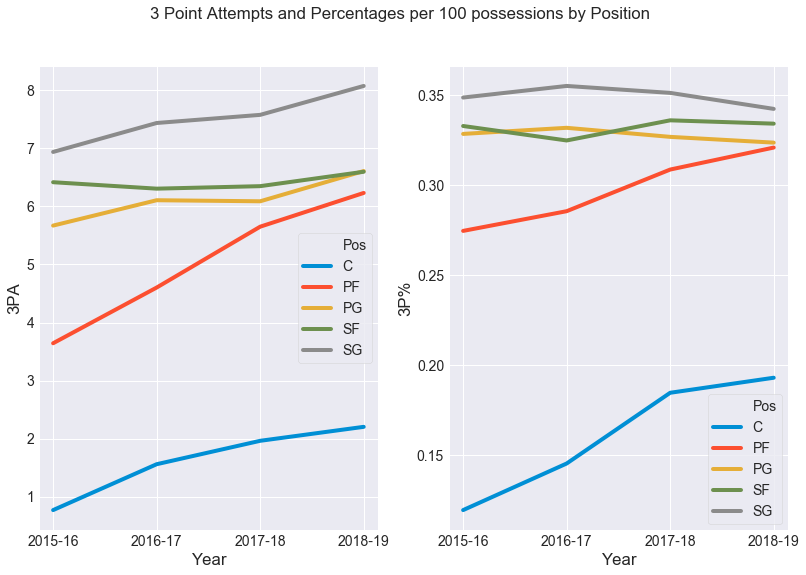

In [20]:
style.use('fivethirtyeight')
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8));
#ax1.set_title('3 Point Attempts per 100 Poss by Position')
#ax2.set_title('3 Point Percentage by Position')
fig.suptitle("3 Point Attempts and Percentages per 100 possessions by Position");
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x='Year', 
             y='3PA',
             hue='Pos', 
             ax = ax1);
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x = 'Year',
             y = '3P%',
             hue = 'Pos',
             ax= ax2);

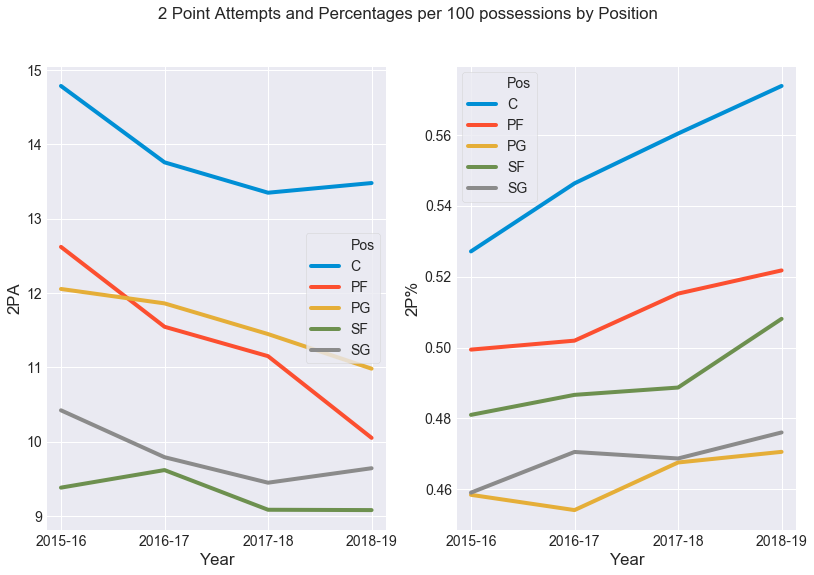

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8));
#ax1.set_title('2 Point Attempts by Position');
#ax2.set_title('2 Point Percentage by Position');
fig.suptitle("2 Point Attempts and Percentages per 100 possessions by Position");
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x='Year', 
             y='2PA',
             hue='Pos', 
             ax = ax1);
sns.lineplot(data = df_cutoff.groupby(['Year', 'Pos']).mean().reset_index(),
             x = 'Year',
             y = '2P%',
             hue = 'Pos',
             ax= ax2);

Text(0.5, 1.0, '2018-2019')

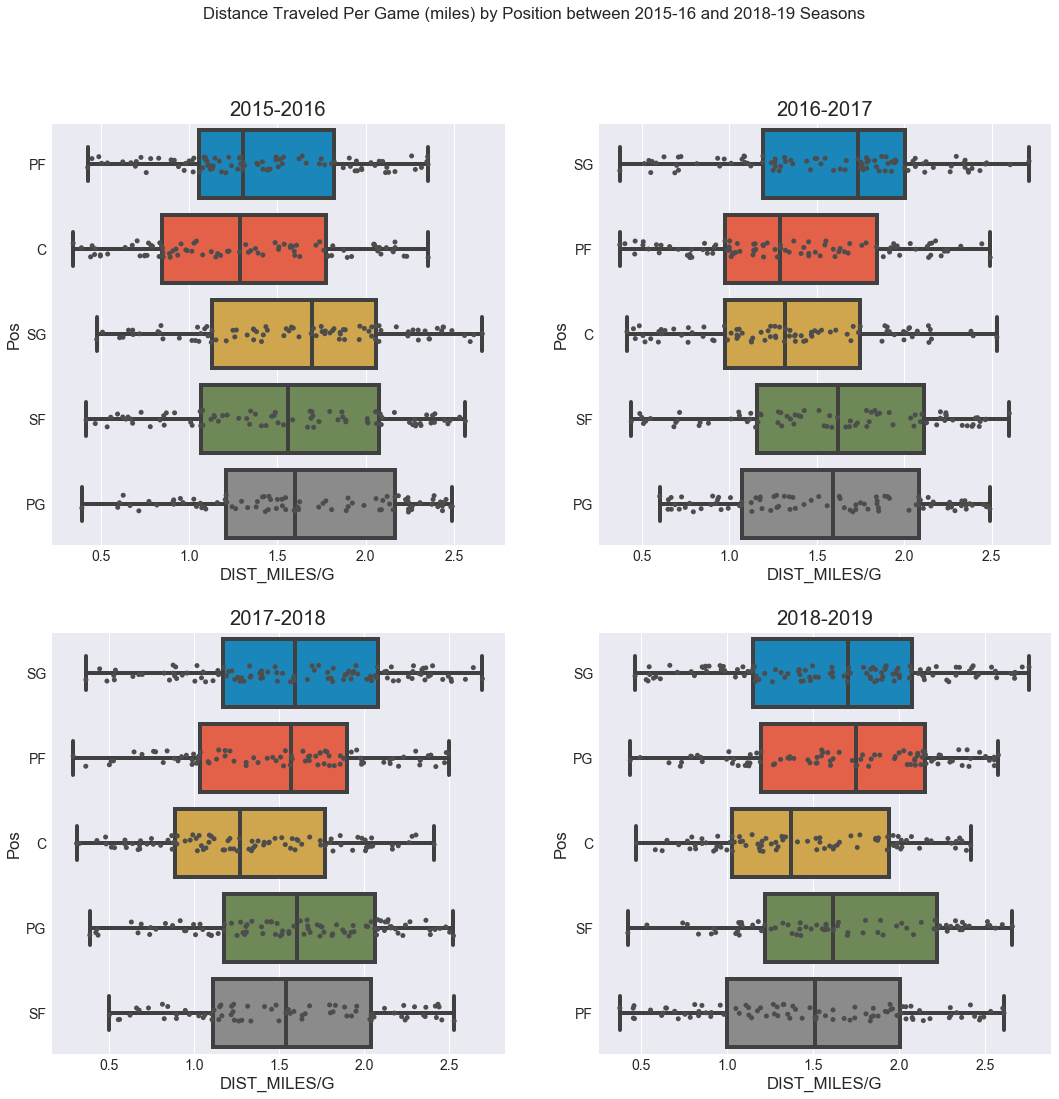

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Offensive Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES_OFF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Defensive Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES_DEF/GM', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')

In [ ]:
#touches, time of possession, front court touches
############################
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Distance Traveled Per Game (miles) by Position between 2015-16 and 2018-19 Seasons')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], 
              color='.3', ax=axs[0][0])
axs[0][0].set_title('2015-2016')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], 
              color='.3', ax=axs[0][1])
axs[0][1].set_title('2016-2017')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], 
              color='.3', ax=axs[1][0])
axs[1][0].set_title('2017-2018')

sns.boxplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
sns.stripplot(x='DIST_MILES/G', y='Pos', data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], 
              color='.3', ax=axs[1][1])
axs[1][1].set_title('2018-2019')

In [ ]:
style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(16, 16));
fig.suptitle('Average VORP by Position between 2015-16 and 2018-19')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2015-16'], ax=axs[0][0])
axs[0][0].set_title('2015-16')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2016-17'], ax=axs[0][1])
axs[0][1].set_title('2016-17')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2017-18'], ax=axs[1][0])
axs[1][0].set_title('2017-18')
sns.barplot(x='Pos', y='VORP', 
            data=df_cutoff.loc[df_cutoff['Year'] == '2018-19'], ax=axs[1][1])
axs[1][1].set_title('2018-19')

In [ ]:
### Look at top 5 VORPs per year for these seasons

In [ ]:
df_cutoff.columns

In [ ]:
df_modeling = df_cutoff.drop(columns=[
       'PLAYER_NAME','Age', 'Tm', 'G', 'GS','MP','DRIVES', '2P', '3P', '2PA', '3P%' 'FT', 'TRB',
       'DRIVE_FGM', 'DRIVE_FGA', 'DRIVE_PASSES', 'CATCH_SHOOT_FGM',
       'CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3M', 'CATCH_SHOOT_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'TIME_OF_POSS', 'PULL_UP_FGM', 'PULL_UP_FGA',
       'PULL_UP_FG3M', 'PULL_UP_FG3A', 'DIST_MILES', 'DIST_MILES_OFF',
       'DIST_MILES_DEF', 'MPG', 'Year', ''])

In [ ]:
#vanilla logistic regression model

X = df_modeling.drop(columns=['Pos'])
y = df_modeling['Pos']

#train test split (75/25, or )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=123)

log_vanilla = LogisticRegression(solver='newton-cg', max_iter=1000)
log_vanilla.fit(X_train, y_train)

In [ ]:
prediction = log_vanilla.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, prediction))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, prediction))

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]
scores = []
for c in C_values:
    log_vanilla = LogisticRegression(solver='newton-cg', max_iter=1000, C=c)
    log_vanilla.fit(X_train, y_train)
    prediction = log_vanilla.predict(X_test)
    score = accuracy_score(y_test, prediction)
    scores.append(score)
    

In [ ]:
scores

In [ ]:
log_vanilla2 = LogisticRegression(solver='newton-cg', max_iter=1000, C=0.01)
log_vanilla2.fit(X_train, y_train)
prediction_train = log_vanilla2.predict(X_train)
prediction_test = log_vanilla2.predict(X_test)

print('-'*40)
print('Training Accuracy Score:')
print(accuracy_score(y_train, prediction_train))

print('-'*40)
print('Testing Accuracy Score:')
print(accuracy_score(y_test, prediction_test))

print('-'*40)
print('Test Confusion Matrix:')
print(confusion_matrix(y_test, prediction_test))

print('-'*40)
print('Test Classification Matrix:')
print(classification_report(y_test, prediction_test))



In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)
log_vanilla3 = LogisticRegression(solver='newton-cg', max_iter=1000, C=0.01)
log_vanilla3.fit(scaled_train, y_train)
prediction3_train = log_vanilla3.predict(scaled_train)
prediction3_test = log_vanilla3.predict(scaled_test)

print(accuracy_score(y_train, prediction3_train))
print(accuracy_score(y_test, prediction3_test))


In [ ]:
###roc curve for multiclass problem

In [ ]:
#Support Vector Machine - RBF
svc_vanilla = SVC(kernel='rbf')

svc_vanilla.fit(X_train, y_train)
svc_prediction_train = svc_vanilla.predict(X_train)
svc_prediction_test = svc_vanilla.predict(X_test)

print('-'*40)
print('Training Accuracy Score:')
print(accuracy_score(y_train, svc_prediction_train))

print('-'*40)
print('Testing Accuracy Score:')
print(accuracy_score(y_test, svc_prediction_test))

print('-'*40)
print('Test Confusion Matrix:')
print(confusion_matrix(y_test, svc_prediction_test))

print('-'*40)
print('Test Classification Matrix:')
print(classification_report(y_test, svc_prediction_test))

In [ ]:
#Support Vector Machine - Polynomial Kernel
degrees = list(range(1, 15))
for d in degrees:
    svc_poly_vanilla = SVC(kernel='poly', degree=d)

    svc_poly_vanilla.fit(X_train, y_train)
    svc_prediction_train = svc_poly_vanilla.predict(X_train)
    svc_prediction_test = svc_poly_vanilla.predict(X_test)
    
    print('-'*40)
    print(f'Degree: {d}')
    
    print('Training Accuracy Score:')
    print(accuracy_score(y_train, svc_prediction_train))

    print('Testing Accuracy Score:')
    print(accuracy_score(y_test, svc_prediction_test))
    print('-'*40)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=150)
rfc.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))


In [ ]:
#XGB Classifier
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=100)
xgb_clf.fit(X_train, y_train)
training_preds = xgb_clf.predict(X_train)
test_preds = xgb_clf.predict(X_test)

print(f"Training Accuracy: {accuracy_score(y_train, training_preds)}")
print(f"Testing Accuracy: {accuracy_score(y_test, test_preds)}")


In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
#K Nearest Neighbor with standard scaler
from sklearn.neighbors import KNeighborsClassifier
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

k_vals = [3, 5, 7, 9, 11]
for k in k_vals:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(scaled_train, y_train)
    knn_test_preds = clf_knn.predict(scaled_test)
    print('-'*40)
    print(f'# of Neighbors: {k}')
    print(accuracy_score(y_test, knn_test_preds))
    print('-'*40)




In [ ]:
#K Nearest Neighbor with Min Max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

k_vals = [3, 5, 7, 9, 11]
for k in k_vals:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(scaled_train, y_train)
    knn_test_preds = clf_knn.predict(scaled_test)
    print('-'*40)
    print(f'# of Neighbors: {k}')
    print(accuracy_score(y_test, knn_test_preds))
    print('-'*40)

In [ ]:
#Hyperparameter Tuning
#Tuning Logistic Regression Model
from sklearn.model_selection import GridSearchCV
log_clf = LogisticRegression()
param_log = {'C':[0.01, 0.1, 1],
             'penalty': ['l2'],
             'solver': ['newton-cg', 'sag', 'lbfgs'], 
             'class_weight': [None, 'balanced'],
             'max_iter': [10000], }

grid_log = GridSearchCV(log_clf, param_grid=param_log, n_jobs=3, scoring='accuracy', cv=7)
grid_log.fit(X_train, y_train)


grid_log.best_params_


In [ ]:
grid_log_train_predictions = grid_log.predict(X_train)
grid_log_test_predictions = grid_log.predict(X_test)

print(f'Training Accuracy Score: {accuracy_score(y_train, grid_log_train_predictions)}')
print(f'Testing Accuracy Score: {accuracy_score(y_test, grid_log_test_predictions)}')

In [ ]:
rf_clf = RandomForestClassifier()
param_rfc = {'criterion': ['gini', 'entropy'],
             'max_depth':[3, 4, 5],
             'min_samples_split': [2, 3, 4, 5],
             'n_estimators': [30, 50, 100, 150, 200]
            }
grid_rfc = GridSearchCV(rf_clf, param_grid=param_rfc, scoring='accuracy', cv=7, n_jobs=3)
grid_rfc.fit(X_train, y_train)

grid_rfc.best_params_

In [ ]:
grid_rfc_train_predictions = grid_rfc.predict(X_train)
grid_rfc_test_predictions = grid_rfc.predict(X_test)

print(f'Training Accuracy Score: {accuracy_score(y_train, grid_rfc_train_predictions)}')
print(f'Testing Accuracy Score: {accuracy_score(y_test, grid_rfc_test_predictions)}')

In [ ]:
xgb_classifier = xgb.XGBClassifier()
param_xgb = {'n_estimators': [30, 50, 100, 150, 200],
             'max_depth':[3, 4, 5, 6],
             'learning_rate': [0.0001, 0.001, 0.01], 
             'booster':['gbtree', 'gblinear', 'dart'],
             'gamma': [0, 1, 10],
             'min_child_weight': [1, 10]
             }
grid_xgb = GridSearchCV(xgb_classifier, param_grid=param_xgb, scoring='accuracy', cv=7, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

In [ ]:
grid_xgb_train_predictions = grid_xgb.predict(X_train)
grid_xgb_test_predictions = grid_xgb.predict(X_test)

print(f'Training Accuracy Score: {accuracy_score(y_train, grid_xgb_train_predictions)}')
print(f'Testing Accuracy Score: {accuracy_score(y_test, grid_xgb_test_predictions)}')

In [ ]:
svc_clf = SVC()
param_svc = [{'C':[0.01, 1, 100, 1000],
             'kernel': ['linear', 'rbf', 'sigmoid'], 
             'gamma': ['scale', 'auto', 0.1, 1.0, 10.0],
             }, 
            {'C':[0.01, 1, 100],
             'kernel': ['poly'],
             'gamma':['scale', 'auto', 0.1, 1.0, 10.0], 
             'degree':[2, 3, 4, 5],
             }]





In [ ]:
svc_clf.fit(X_train, y_train)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X.columns, vif))

In [ ]:
X_corr = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
X_corr['pairs'] = list(zip(X_corr.level_0, X_corr.level_1))

# set index to pairs
X_corr.set_index(['pairs'], inplace = True)

#drop level columns
X_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
X_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
X_corr.drop_duplicates(inplace=True)

In [ ]:
X_corr[(X_corr.cc > 0.75) & (X_corr.cc < 1)]

In [ ]:
df_cutoff['MPG'].hist()

In [ ]:
df_modeling['Pos'].value_counts()

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)

In [ ]:
dict(zip(unique, counts))